In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume/train.csv")
df.head()

,ID,Resume_str,Category
0,28111403,president chief executive officer executive pr...,INFORMATION-TECHNOLOGY
1,29908929,business development marketing summary busines...,BUSINESS-DEVELOPMENT
2,15261348,chef and restaurant manager summary chef with ...,CHEF
3,75435017,charge nurse professional summary objective to...,HEALTHCARE
4,41152404,test analyst intern contractor profile years o...,INFORMATION-TECHNOLOGY


In [3]:
# Convert resumes column to a list
resumes = df["Resume_str"].tolist()
    
# Encode category labels as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(df["Category"])
category_names = encoder.classes_.tolist()

In [4]:
# Load the SBERT model for generating sentence embeddings
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [5]:
# Generate SBERT embeddings
resumes_embed = sbert_model.encode(resumes, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

### Support Vector Machine

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
class_counts = df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())
sampling_strategy = {i: target_size for i, cls in enumerate(min_classes)}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [11]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', SVC(probability=True, random_state=42))
])

In [12]:
param_grid = [
    {
        'clf__kernel': ['linear'],
        'clf__C':      [1]
    },
    {
        'clf__kernel': ['rbf'],
        'clf__C': [10],
        'clf__gamma': [1, 'scale']
    },
    {
        'clf__kernel': ['poly'],
        'clf__C':      [1],
        'clf__degree': [2, 3],              
        'clf__coef0': [0.1, 1.0]
    }
]

scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= scoring,
    refit = False,
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(resumes_embed, labels)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")

GridSearchCV took 27.19 seconds for 7 candidates parameter settings.



In [13]:
# Convert the cross-validation results from GridSearchCV into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort the results by the weighted F1 score in descending order
results_df = results_df.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

In [14]:
for i in range(len(results_df)):
    print(f"\n[{i+1}] Params: {results_df['params'][i]}")
    
    for metric in scoring:
        
        print(f"{metric.upper()}:")
        print(f"\tTRAIN:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_train_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_train_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_train_{metric}'][i]:.4f}")

        print(f"\tTEST:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_test_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_test_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_test_{metric}'][i]:.4f}\n")


[1] Params: {'clf__C': 1, 'clf__coef0': 0.1, 'clf__degree': 3, 'clf__kernel': 'poly'}
ACCURACY:
	TRAIN:	Fold 1: 0.9811	Fold 2: 0.9799	Fold 3: 0.9799	Fold 4: 0.9773	Fold 5: 0.9761		Mean: 0.9789	Std: 0.0018
	TEST:	Fold 1: 0.7789	Fold 2: 0.7305	Fold 3: 0.7380	Fold 4: 0.7380	Fold 5: 0.7632		Mean: 0.7497	Std: 0.0183

F1_WEIGHTED:
	TRAIN:	Fold 1: 0.9811	Fold 2: 0.9799	Fold 3: 0.9800	Fold 4: 0.9773	Fold 5: 0.9761		Mean: 0.9789	Std: 0.0019
	TEST:	Fold 1: 0.7755	Fold 2: 0.7310	Fold 3: 0.7392	Fold 4: 0.7390	Fold 5: 0.7603		Mean: 0.7490	Std: 0.0164

PRECISION_WEIGHTED:
	TRAIN:	Fold 1: 0.9816	Fold 2: 0.9806	Fold 3: 0.9806	Fold 4: 0.9780	Fold 5: 0.9767		Mean: 0.9795	Std: 0.0018
	TEST:	Fold 1: 0.7883	Fold 2: 0.7583	Fold 3: 0.7479	Fold 4: 0.7493	Fold 5: 0.7691		Mean: 0.7626	Std: 0.0149

RECALL_WEIGHTED:
	TRAIN:	Fold 1: 0.9811	Fold 2: 0.9799	Fold 3: 0.9799	Fold 4: 0.9773	Fold 5: 0.9761		Mean: 0.9789	Std: 0.0018
	TEST:	Fold 1: 0.7789	Fold 2: 0.7305	Fold 3: 0.7380	Fold 4: 0.7380	Fold 5: 0.7632		Mean: 0

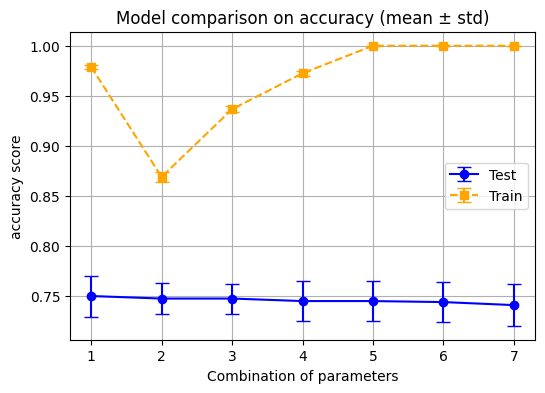

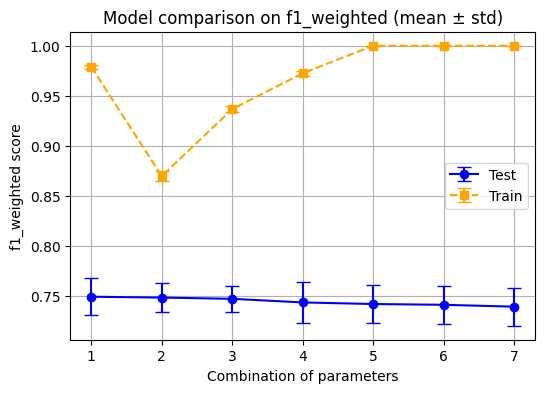

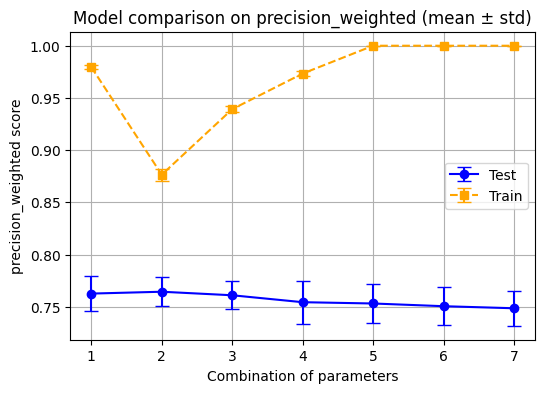

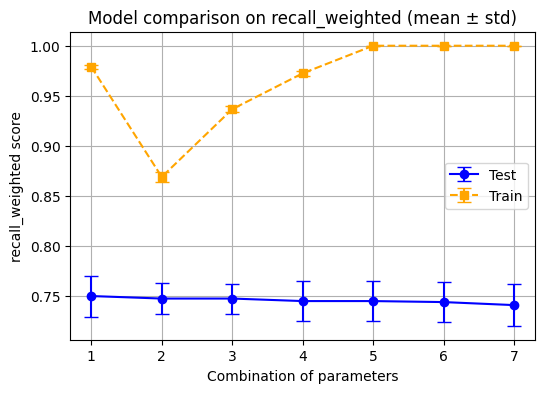

In [15]:
for metric in scoring:
    data_test = {}
    data_train = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data_test[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]
        data_train[col_name] = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_test = pd.DataFrame(data_test)
    df_train = pd.DataFrame(data_train)

    means_test = df_test.mean()
    stds_test = df_test.std()
    means_train = df_train.mean()
    stds_train = df_train.std()

    plt.figure(figsize=(max(6, len(results_df) * 0.75), 4))

    plt.errorbar(means_test.index, means_test.values, yerr=stds_test.values, fmt='-o', capsize=5, label='Test', color='blue')

    plt.errorbar(means_train.index, means_train.values, yerr=stds_train.values, fmt='--s', capsize=5, label='Train', color='orange')

    plt.ylabel(f'{metric} score')
    plt.xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric} (mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.show()

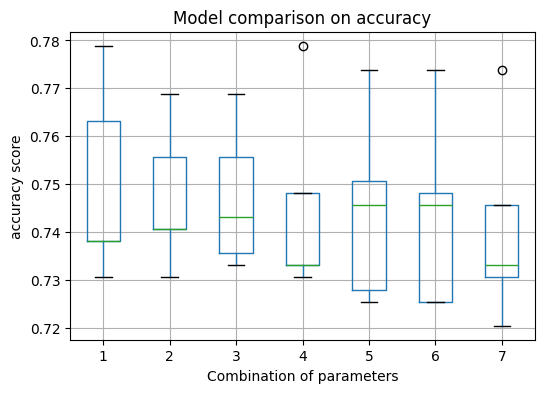

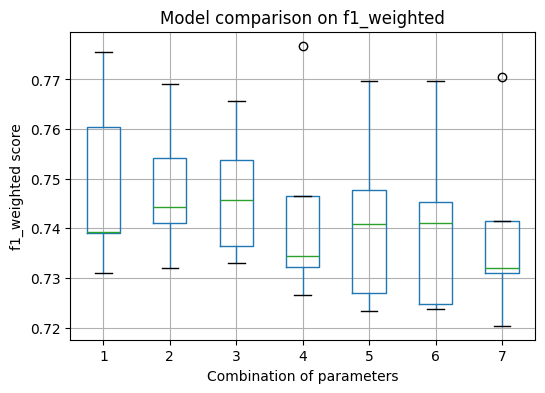

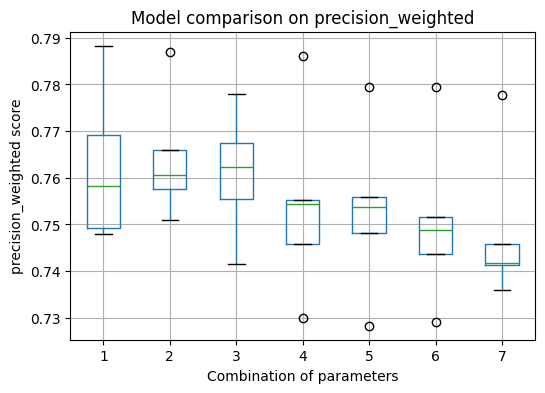

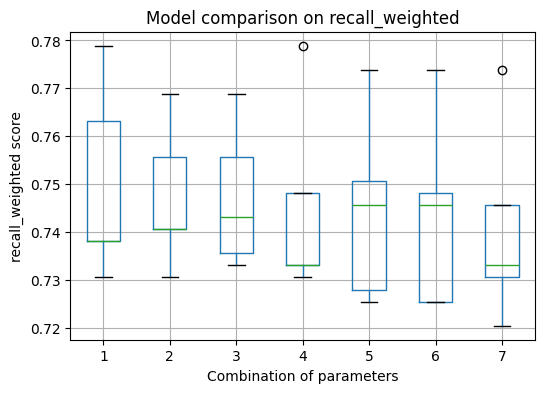

In [16]:
for metric in scoring:
    data = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_metric = pd.DataFrame(data)
    ax = df_metric.boxplot(figsize=(max(6, len(results_df) * 0.75), 4))
    ax.set_ylabel(f'{metric} score')
    ax.set_xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric}')
    plt.grid(True)
    plt.show()

In [17]:
output_file = "compare/results.json"
section_key = "SBERT"

# Only process the first row
i = 0
entry = {
    "params": results_df['params'][i],
    "metrics": {}
}

for metric in scoring:
    train_folds = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]
    test_folds = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    entry["metrics"][metric] = {
        "train": {
            "folds": train_folds,
            "mean": results_df[f'mean_train_{metric}'][i],
            "std": results_df[f'std_train_{metric}'][i]
        },
        "test": {
            "folds": test_folds,
            "mean": results_df[f'mean_test_{metric}'][i],
            "std": results_df[f'std_test_{metric}'][i]
        }
    }

# Load or initialize the JSON structure
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        data = json.load(f)
else:
    data = {}

data[section_key] = entry

# Write the full updated JSON back to file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Saved the best model")

Saved the best model
